<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [0]:
!pip install --pre --quiet astroquery

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0-rc1


## Datos del SDSS

Disponible en enlace



###Consulta con Astroquery###

In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 1000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z, s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'STAR'
                      
                      """)

In [144]:
datapd=data.to_pandas()
print(datapd)

     fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0      19.78761    18.81021    18.55947    18.44454    18.41792        6500
1      20.46545    18.85142    18.35061    18.20708    18.03558        5320
2      21.36420    19.53852    18.79207    18.48760    18.21579        4576
3      21.54065    19.62002    18.69980    18.26637    17.98270        4576
4      22.42662    20.11089    18.85497    17.81604    17.23922        3717
5      21.31945    19.43962    18.75341    18.42968    18.18701        4955
6      20.62838    18.82706    18.13433    17.83871    17.72808        4955
7      21.05210    19.52236    18.93390    18.62222    18.50867        4576
8      22.26805    20.22126    18.81904    17.37300    16.61288        3717
9      21.86569    19.46522    18.28040    17.74466    17.46696        4382
10     23.29790    20.16792    18.85043    17.69284    17.09843        3717
11     22.67853    19.79411    18.46184    17.82746    17.47438        3962
12     20.34

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)

### Chequeo a los datos

Estadísticas:

In [146]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,800.0,20.480484,1.625181,15.83426,19.277552,20.448785,21.673005,25.63970
fiberMag_g,800.0,18.805455,1.304918,15.50642,18.068905,18.783845,19.495730,25.92659
fiberMag_r,800.0,18.078315,1.122959,15.37330,17.409698,17.919350,18.649645,23.09650
fiberMag_i,800.0,17.701242,1.063031,15.15979,17.018620,17.571545,18.241697,21.89202
fiberMag_z,800.0,17.498758,1.116159,14.72477,16.778263,17.352450,18.067698,21.42704


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [0]:
norm_train_labels = norm(train_labels)
norm_train_feat = norm(train_feat)

norm_test_feat = norm(test_feat)

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

###Estructura de la red neuronal

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    layers.Dense(5, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

###Desnormalización

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo

### Inspección del modelo

In [160]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [161]:
# Imprime un punto por cada epoch completado
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

El progreso de entrenamiento del sistema está en el objeto `history`.

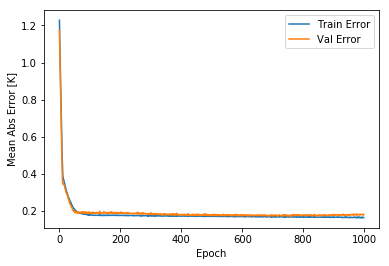

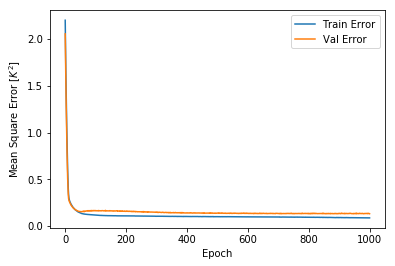

In [162]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

###Tiempo de Ejecución

In [0]:
t_fin = time()
t_ejecucion = t_fin - t_ini

### Predicción con los datos de prueba

(3296.6023681640627, 9969.006598318068, 3296.5871915636208, 9968.991421717627)

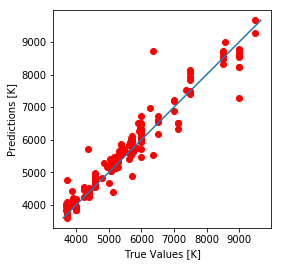

In [164]:
test_predictions = model.predict(norm_test_feat).flatten()

test_predictions = desnorm(test_predictions, train_labels.mean(), train_labels.std())
m1 = min(test_labels)
M1 = max(test_labels)

m2 = min(test_predictions)
M2 = max(test_predictions)

m = min([m1, m2])
M = max([M1, M2])

plt.scatter(test_labels, test_predictions, color='red')
plt.plot([m , M], [m, M])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

Notemos que nuestro modelo se debe acercar a la función de  identidad. Ahora veamos la distribución del error absoluto:



Tiempo de Ejecución: 144.86824870109558
Error Absoluto Medio: 91.15381469726563


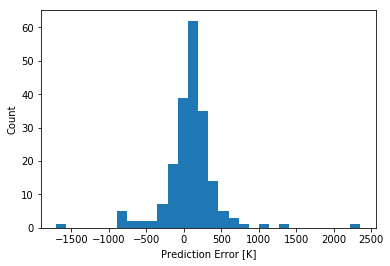

In [165]:
error = test_predictions - test_labels

plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

MeanAbsError = error.mean()

print('Tiempo de Ejecución:', t_ejecucion)
print('Error Absoluto Medio:', MeanAbsError)